In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

metlin = pd.read_parquet(
    "ccs-prediction/metlin-clean-all-columns.parquet"
)

In [3]:
metlin["correct_CCS_avg"] = round(
    ((metlin["CCS1"] + metlin["CCS2"] + metlin["CCS3"]) / 3), 2
)

In [4]:
# calculate murcko scaffolds using smiles
from rdkit import Chem
from rdkit.Chem import rdmolops


def get_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        murcko_scaffold = rdmolops.MurckoDecompose(mol)
        return Chem.MolToSmiles(murcko_scaffold)
    else:
        print("Molecule creation failed.")
        return None


metlin["murcko_scaffold"] = metlin["smiles"].apply(get_murcko_scaffold)

[10:47:59] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


Molecule creation failed.


[10:48:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18


Molecule creation failed.


[10:48:02] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Molecule creation failed.


[10:48:05] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Molecule creation failed.


[10:48:08] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[10:48:08] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


Molecule creation failed.
Molecule creation failed.


[10:48:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Molecule creation failed.


In [5]:
metlin = metlin.dropna(subset=["murcko_scaffold"])

In [6]:
print(f"unique murcko scaffolds = {metlin.murcko_scaffold.nunique()}")
print(f"unique smiles = {metlin.smiles.nunique()}")
print(
    f"unique smiles / unique murcko scaffolds = {(metlin.smiles.nunique() / metlin.murcko_scaffold.nunique())}"
)

unique murcko scaffolds = 17552
unique smiles = 27629
unique smiles / unique murcko scaffolds = 1.5741226071103007


In [7]:
metlin.murcko_scaffold.value_counts()

murcko_scaffold
c1ccccc1                                          1656
O=C(NCc1ccccc1)c1ccccc1                            523
O=C1NC(=O)C(c2ccccc2)N1                            447
O=C(Nc1ccccc1)c1ccccc1                             437
O=C1NC(c2ccccc2)C(=O)N1Cc1ccccc1                   248
                                                  ... 
C1=Nc2nc3ccccc3n2C(c2ccccc2N2CCCC2)N1                1
O=C(CCc1nc(-c2ccccc2)c(-c2ccccc2)o1)NCc1ccccc1       1
O=C(OCC=Cc1ccccc1)c1nc2ncccn2n1                      1
O=C(CNCc1ccco1)Nc1cc2c(s1)CCC2                       1
O=S(=O)(Nc1nc2ccccc2nc1N1CCCC1)c1ccsc1               1
Name: count, Length: 17552, dtype: int64

<Axes: >

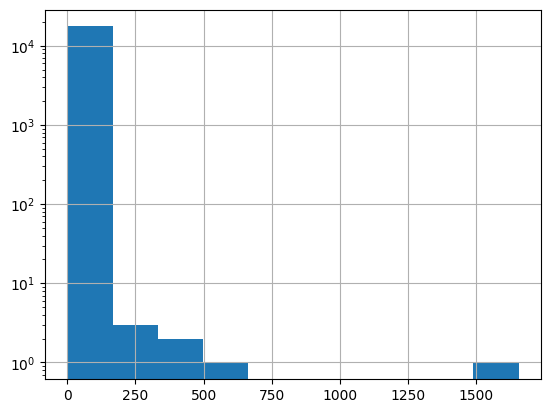

In [8]:
metlin.murcko_scaffold.value_counts().hist(log=True)

In [9]:
metlin.groupby("murcko_scaffold")["smiles"].value_counts()

murcko_scaffold  smiles                         
                 CC(CCC(NC(=O)CCCNC(=O)N)C)C        2
                 CCN(CC(=O)NC(C)C)CC(=O)NC(C)C      2
                 CC(NCCCNC(C)(C)C)(C)C              1
                 CCCCC(C(=O)N)(CCCC)CCCC            1
                 CCCCCCCNCCCCCCC                    1
                                                   ..
c1nnn[nH]1       O=C(C(Sc1nnnn1C(C)C)C)NC(C)(C)C    3
                 CC(Cn1nnnc1SCC(=O)NC(C)(C)C)C      2
                 CC(NC(=O)CSc1nnnn1C(C)C)C          2
                 CCn1nnnc1SCC(=O)NC(C)C             2
c1nnnn1C1CCCC1   CC(NC(=O)C(Sc1nnnn1C1CCCC1)C)C     3
Name: count, Length: 27629, dtype: int64

<Axes: >

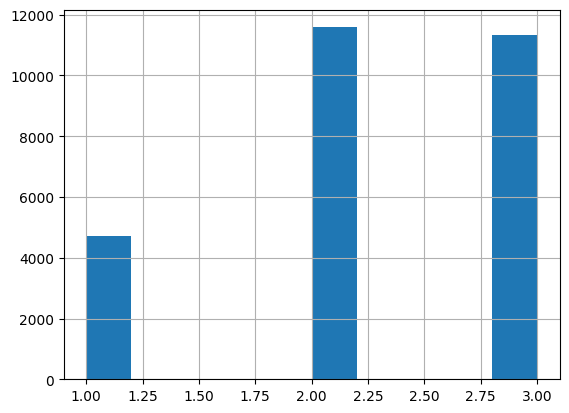

In [10]:
metlin.groupby("murcko_scaffold")["smiles"].value_counts().hist()

In [11]:
# for a given murcko scaffold, how many unique smiles are there?
metlin.groupby("murcko_scaffold")["smiles"].nunique()

murcko_scaffold
                                           7
C(=C1CCCc2cc3ccccc3nc21)c1ccc2c(c1)OCO2    1
C(=C1CCCc2cc3ccccc3nc21)c1ccccc1           1
C(=C1CCc2cc3ccccc3nc21)c1ccco1             1
C(=Cc1cc2ccccc2o1)c1nc2ccccc2[nH]1         1
                                          ..
c1nnc(SCc2ccc3c(c2)OCO3)s1                 1
c1nnc[nH]1                                 3
c1nncs1                                    2
c1nnn[nH]1                                 4
c1nnnn1C1CCCC1                             1
Name: smiles, Length: 17552, dtype: int64

# CCSBASE

In [12]:
ccsbase = pd.read_parquet(
    "ccs-prediction/ccs_base_experimental_clean.parquet"
)

ccbase_duplicates = pd.read_parquet(
    "ccs-prediction/ccs_base_experimental_clean_w_duplicates.parquet"
)

In [13]:
ccsbase["murcko_scaffold"] = ccsbase["smiles"].apply(get_murcko_scaffold)
ccsbase = ccsbase.dropna(subset=["murcko_scaffold"])

In [14]:
ccbase_duplicates["murcko_scaffold"] = ccbase_duplicates["smiles"].apply(
    get_murcko_scaffold
)
ccbase_duplicates = ccbase_duplicates.dropna(subset=["murcko_scaffold"])

### Draw scaffolds
```python
us = ccsbase.loc[ccsbase["murcko_scaffold"] == ""].smiles.unique()

#draw in rdkit
from rdkit import Chem
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smiles) for smiles in us]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(600, 600))
img
```

In [15]:
ccsbase.loc[ccsbase["murcko_scaffold"] == ""]["mol_type"].value_counts()

mol_type
lipid             1946
small molecule     912
peptide             33
carbohydrate        26
Name: count, dtype: int64

In [16]:
print(f"unique murcko scaffolds = {ccsbase.murcko_scaffold.nunique()}")
print(f"unique smiles = {ccsbase.smiles.nunique()}")
print(
    f"unique smiles / unique murcko scaffolds = {(ccsbase.smiles.nunique() / ccsbase.murcko_scaffold.nunique())}"
)

unique murcko scaffolds = 1561
unique smiles = 6075
unique smiles / unique murcko scaffolds = 3.891736066623959


<Axes: >

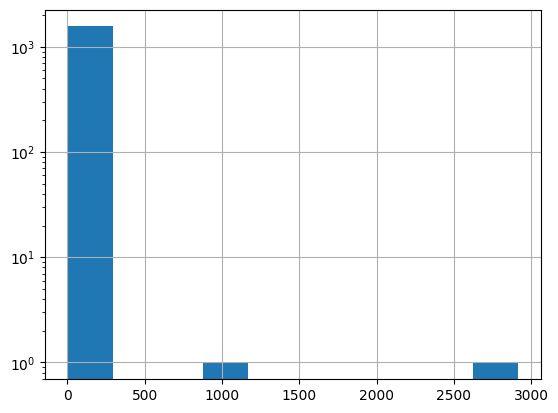

In [17]:
ccsbase.murcko_scaffold.value_counts().hist(log=True)

<Axes: >

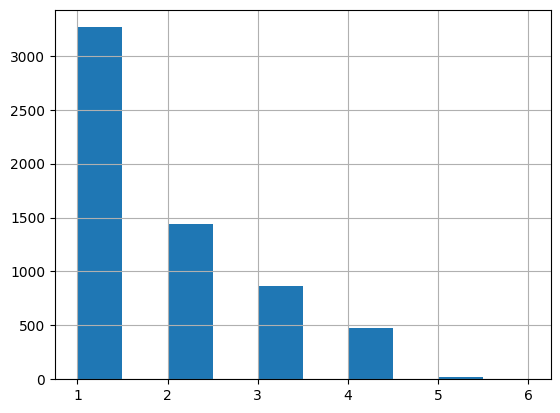

In [18]:
ccsbase.groupby("murcko_scaffold")["smiles"].value_counts().hist()

<Axes: >

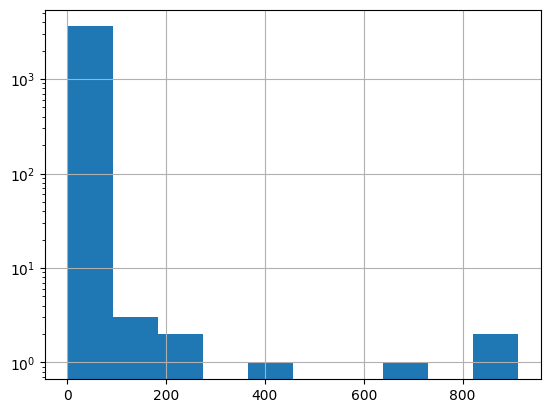

In [19]:
ccsbase.groupby(["murcko_scaffold", "Adduct"]).size().hist(log=True)

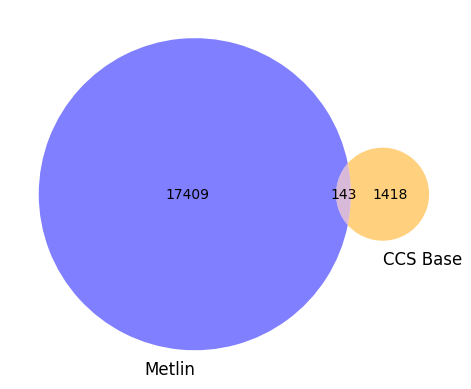

In [20]:
# Overlap between the two datasets based on murcko scaffolds
import matplotlib_venn as venn

metlin_murcko = set(metlin.murcko_scaffold.unique())
ccsbase_murcko = set(ccsbase.murcko_scaffold.unique())

venn.venn2(
    [metlin_murcko, ccsbase_murcko],
    set_labels=["Metlin", "CCS Base"],
    set_colors=["blue", "orange"],
    alpha=0.5,
)

# Get duplicates of Metlin data

In [21]:
metlin_duplicates = metlin.copy()
metlin_duplicates = metlin_duplicates[
    ["CCS1", "CCS2", "CCS3", "Dimer.1", "smiles", "murcko_scaffold", "Adduct"]
].rename(columns={"Dimer.1": "dimer", "Adduct": "adduct"})

In [22]:
# make a duplicate rows for metlin_duplicates (one with CCS1, one with CCS2, one with CCS3)
metlin_duplicates = metlin_duplicates.melt(
    id_vars=["smiles", "murcko_scaffold", "dimer", "adduct"],
    value_vars=["CCS1", "CCS2", "CCS3"],
    var_name="ccs_number",
    value_name="ccs",
)

In [23]:
metlin_duplicates.drop(columns=["ccs_number"], inplace=True)

In [24]:
print(metlin_duplicates.shape)
metlin_duplicates.drop_duplicates(subset=["smiles", "adduct", "ccs"], inplace=True)
print(metlin_duplicates.shape)

(185565, 5)
(170898, 5)


# Get data columns

In [25]:
metlin = metlin[
    ["correct_CCS_avg", "Dimer.1", "smiles", "murcko_scaffold", "Adduct"]
].rename(columns={"Dimer.1": "dimer", "Adduct": "adduct", "correct_CCS_avg": "ccs"})

In [26]:
ccsbase = ccsbase.rename(columns={"SMILES": "smiles", "CCS": "ccs", "Adduct": "adduct"})
ccbase_duplicates = ccbase_duplicates.rename(
    columns={"SMILES": "smiles", "CCS": "ccs", "Adduct": "adduct"}
)

In [27]:
# concatenate
metlin["source"] = "metlin"
ccsbase["source"] = "ccsbase"

In [28]:
metlin_duplicates["source"] = "metlin"
ccbase_duplicates["source"] = "ccsbase"

In [29]:
# some of the adducts in metlin are not in the right format
adduct_mapping_fix = {
    "[M+H]": "[M+H]+",
    "[M-H]": "[M-H]-",
    "[M+Na]": "[M+Na]+",
}
metlin.adduct = metlin.adduct.replace(adduct_mapping_fix)
metlin_duplicates.adduct = metlin_duplicates.adduct.replace(adduct_mapping_fix)

In [30]:
# according to tobias, metlin adduct annotations are incorrect for dimers
adduct_mapping_fix_for_dimers = {
    "[M+H]+": "[2M+H]+",
    "[M-H]-": "[2M-H]-",
    "[M+Na]+": "[2M+Na]+",
}
metlin.loc[metlin["dimer"] == "Dimer", "adduct"] = metlin.loc[
    metlin["dimer"] == "Dimer", "adduct"
].map(adduct_mapping_fix_for_dimers)
metlin_duplicates.loc[metlin_duplicates["dimer"] == "Dimer", "adduct"] = (
    metlin_duplicates.loc[metlin_duplicates["dimer"] == "Dimer", "adduct"].map(
        adduct_mapping_fix_for_dimers
    )
)

In [31]:
metlin.loc[metlin["dimer"] == "Dimer"].adduct.value_counts()

adduct
[2M+Na]+    2402
[2M+H]+     1089
[2M-H]-      331
Name: count, dtype: int64

In [32]:
metlin_duplicates.loc[metlin_duplicates["dimer"] == "Dimer"].adduct.value_counts()

adduct
[2M+Na]+    6651
[2M+H]+     3006
[2M-H]-      926
Name: count, dtype: int64

In [33]:
# ccsbase does not have dimer monomer labels so we will add them based on the adduct labels
ccsbase["dimer"] = "Monomer"
ccsbase.loc[ccsbase["adduct"].str.contains("2M"), "dimer"] = "Dimer"

ccbase_duplicates["dimer"] = "Monomer"
ccbase_duplicates.loc[ccbase_duplicates["adduct"].str.contains("2M"), "dimer"] = "Dimer"

In [34]:
combined = pd.concat([metlin, ccsbase])

In [35]:
combined_w_duplicates = pd.concat([metlin_duplicates, ccbase_duplicates])

In [36]:
# add molecular type (mol_type)
combined.loc[combined["source"] == "metlin", "mol_type"] = "small molecule"
combined_w_duplicates.loc[combined_w_duplicates["source"] == "metlin", "mol_type"] = (
    "small molecule"
)

In [37]:
# add ccs_type (TIMS DTIMS etc.)
combined.loc[combined["source"] == "metlin", "ccs_type"] = "TIMS"
combined_w_duplicates.loc[combined_w_duplicates["source"] == "metlin", "ccs_type"] = (
    "TIMS"
)

In [ ]:
# drugtax
import drugtax


def get_drugtax(row):
    try:
        return [
            1 if value > 0 else 0
            for feature, value in drugtax.DrugTax(row["smiles"]).features.items()
            if not feature.startswith("char")
        ]
    except Exception as e:
        raise e


combined["drugtax"] = combined.apply(get_drugtax, axis=1)
combined_w_duplicates["drugtax"] = combined_w_duplicates.apply(get_drugtax, axis=1)

## Plot chemical space

In [98]:
from rdkit import Chem
from rdkit.Chem import AllChem
from functools import cache

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

from tqdm import tqdm

In [41]:
ccsbase_smiles = ccsbase["smiles"].unique()
metlin_smiles = metlin["smiles"].unique()

In [92]:
@cache
def get_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None


@cache
def get_fingerprint(smiles):
    mol = get_mol(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)

In [44]:
ccsbase_fingerprints = [get_fingerprint(smiles) for smiles in tqdm(ccsbase_smiles)]
metlin_fingerprints = [get_fingerprint(smiles) for smiles in tqdm(metlin_smiles)]

100%|██████████| 27629/27629 [00:03<00:00, 7242.81it/s]


In [45]:
# Make a dataframe with three columns - one for the smiles and one for the fingerprints and one for the source
ccsbase_fingerprints_df = pd.DataFrame(
    {
        "smiles": ccsbase_smiles,
        "fingerprints": ccsbase_fingerprints,
        "source": "ccsbase",
    }
)

metlin_fingerprints_df = pd.DataFrame(
    {"smiles": metlin_smiles, "fingerprints": metlin_fingerprints, "source": "metlin"}
)

fingerprints_df = pd.concat([ccsbase_fingerprints_df, metlin_fingerprints_df])

In [46]:
fingerprints_df["source"].value_counts()

source
metlin     27629
ccsbase     6075
Name: count, dtype: int64

In [86]:
# Make a ndarray with the fingerprints and then use TSNE to reduce the dimensionality
fingerprints = np.array(fingerprints_df["fingerprints"].tolist())

tsne = TSNE(n_components=2, random_state=42, perplexity=30)

fingerprints_tsne = tsne.fit_transform(fingerprints)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 33704 samples in 0.002s...
[t-SNE] Computed neighbors for 33704 samples in 2.735s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33704
[t-SNE] Computed conditional probabilities for sample 2000 / 33704
[t-SNE] Computed conditional probabilities for sample 3000 / 33704
[t-SNE] Computed conditional probabilities for sample 4000 / 33704
[t-SNE] Computed conditional probabilities for sample 5000 / 33704
[t-SNE] Computed conditional probabilities for sample 6000 / 33704
[t-SNE] Computed conditional probabilities for sample 7000 / 33704
[t-SNE] Computed conditional probabilities for sample 8000 / 33704
[t-SNE] Computed conditional probabilities for sample 9000 / 33704
[t-SNE] Computed conditional probabilities for sample 10000 / 33704
[t-SNE] Computed conditional probabilities for sample 11000 / 33704
[t-SNE] Computed conditional probabilities for sample 12000 / 33704
[t-SNE] Computed conditional probabilities for sam

In [87]:
# Store the first and second components of the TSNE in the dataframe
fingerprints_df["tsne_1"] = fingerprints_tsne[:, 0]
fingerprints_df["tsne_2"] = fingerprints_tsne[:, 1]

/var/folders/6q/xdd_zynj36q_nl9dhb_0l72w0000gn/T/ipykernel_9311/2892159131.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


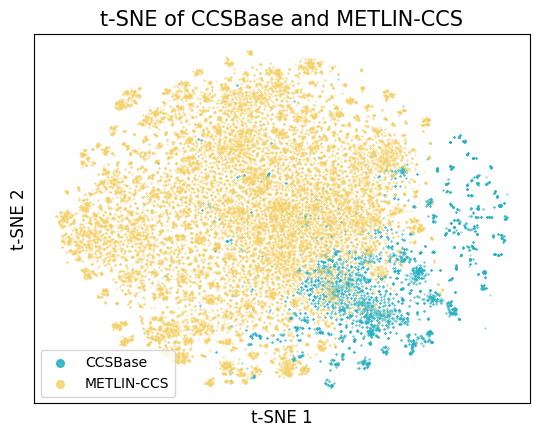

In [97]:
fig, ax = plt.subplots()

# Plot the ccsbase points and metlin points with different colors
ccsbase_pca = fingerprints_df.loc[fingerprints_df["source"] == "ccsbase"]
metlin_pca = fingerprints_df.loc

ax.scatter(
    fingerprints_df[fingerprints_df["source"] == "ccsbase"]["tsne_1"],
    fingerprints_df[fingerprints_df["source"] == "ccsbase"]["tsne_2"],
    label="CCSBase",
    color="#29b1c4",
    alpha=0.9,
    s=0.1,
)

ax.scatter(
    fingerprints_df[fingerprints_df["source"] == "metlin"]["tsne_1"],
    fingerprints_df[fingerprints_df["source"] == "metlin"]["tsne_2"],
    label="METLIN-CCS",
    color="#f6d063",
    # transparency
    alpha=0.8,
    # size point
    s=0.1,
)


# Plot legend.
lgnd = plt.legend(loc="lower left", numpoints=1, fontsize=10)

# Title
plt.title("t-SNE of CCSBase and METLIN-CCS", fontsize=15)

# Increase marker size in the legend
for handle in lgnd.legendHandles:
    handle._sizes = [30]

# Change axis to t-SNE 1 and t-SNE 2
plt.xlabel("t-SNE 1", fontsize=12)
plt.ylabel("t-SNE 2", fontsize=12)

# remove ticks
plt.xticks([])
plt.yticks([])

# save figure
plt.savefig("t-SNE.png", dpi=500)

plt.show()

Calculate the max Tanimoto similarity between the two datasets

In [95]:
max_sim = []

for smiles_1 in tqdm(ccsbase_smiles):
    max_sim.append(
        max(
            [
                AllChem.DataStructs.TanimotoSimilarity(
                    get_fingerprint(smiles_1), get_fingerprint(smiles_metlin)
                )
                for smiles_metlin in metlin_smiles
            ]
        )
    )

100%|██████████| 6075/6075 [06:24<00:00, 15.82it/s]


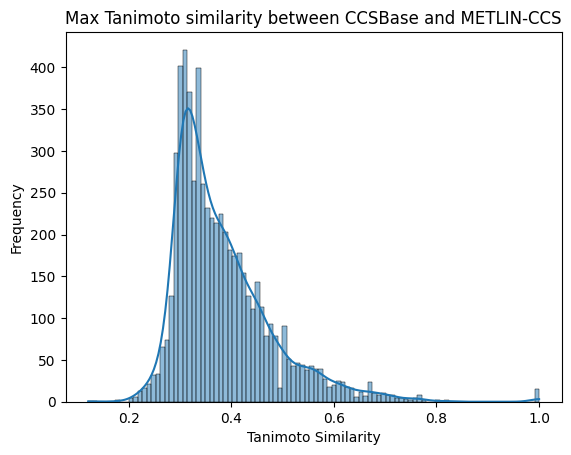

In [100]:
# Plot the distribution with seaborn

sns.histplot(max_sim, bins=100, kde=True)

plt.xlabel("Tanimoto Similarity")
plt.ylabel("Frequency")

plt.title("Max Tanimoto similarity between CCSBase and METLIN-CCS")

# save
plt.savefig("max_tanimoto_similarity.png", dpi=500)

plt.show()

# save to s3

In [39]:
# this is the big combined dataset
combined.to_parquet(
    "ccs-prediction/combined_metlin_ccsbase.parquet"
)

In [40]:
combined_w_duplicates.to_parquet(
    "ccs-prediction/combined_metlin_ccsbase_w_duplicates.parquet"
)

In [ ]:
combined.adduct.value_counts()

adduct
[M+H]+        28824
[M-H]-        19911
[M+Na]+       17638
[2M+Na]+       2431
[M+K]+         1111
[2M+H]+        1099
[M+H-H2O]+      938
[2M-H]-         363
[M+NH4]+        320
Name: count, dtype: int64

In [ ]:
combined.dimer.value_counts()

dimer
Monomer    68742
Dimer       3893
Name: count, dtype: int64

In [ ]:
combined["type_dimer"] = combined["mol_type"] + "_" + combined["dimer"]
combined_w_duplicates["type_dimer"] = (
    combined_w_duplicates["mol_type"] + "_" + combined_w_duplicates["dimer"]
)
combined["type_dimer"].value_counts()

type_dimer
small molecule_Monomer    66205
small molecule_Dimer       3893
lipid_Monomer              2288
carbohydrate_Monomer        148
peptide_Monomer             101
Name: count, dtype: int64

In [ ]:
# replace empty or benzene murcko scaffolds with the smiles
combined["murcko_scaffold"] = combined.apply(
    lambda x: (
        x["smiles"]
        if (x["murcko_scaffold"] == "") or (x["murcko_scaffold"] == "c1ccccc1")
        else x["murcko_scaffold"]
    ),
    axis=1,
)
combined_w_duplicates["murcko_scaffold"] = combined_w_duplicates.apply(
    lambda x: (
        x["smiles"]
        if (x["murcko_scaffold"] == "") or (x["murcko_scaffold"] == "c1ccccc1")
        else x["murcko_scaffold"]
    ),
    axis=1,
)

# check that this worked
combined.loc[
    (combined["murcko_scaffold"] == "") | (combined["murcko_scaffold"] == "c1ccccc1")
].empty, combined_w_duplicates.loc[
    (combined_w_duplicates["murcko_scaffold"] == "")
    | (combined_w_duplicates["murcko_scaffold"] == "c1ccccc1")
].empty

(True, True)

# Make sure there aren't any duplicates

In [ ]:
# make a murcko + adduct column for easy splitting (just like smiles adduct from last time)
combined["smiles_adduct"] = combined["smiles"] + "_" + combined["adduct"]

In [ ]:
combined["value_counts"] = combined.smiles_adduct.map(
    combined.smiles_adduct.value_counts()
)

In [ ]:
combined["value_counts"].value_counts()

value_counts
1    72635
Name: count, dtype: int64

# Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

split_dict = {"train": [], "test": []}

for category in combined["type_dimer"].unique():
    train, test = train_test_split(
        combined.loc[combined["type_dimer"] == category, "murcko_scaffold"].unique(),
        test_size=0.2,
        random_state=42,
    )
    split_dict["train"].append(train)
    split_dict["test"].append(test)

train = pd.concat([pd.Series(x) for x in split_dict["train"]], ignore_index=True)
test = pd.concat([pd.Series(x) for x in split_dict["test"]], ignore_index=True)

In [ ]:
len(set(train).intersection(set(test))), len(set(train)), len(set(test))

In [ ]:
# get common items
common = set(train).intersection(set(test))

# split them also
common_train, common_test = train_test_split(
    list(common), test_size=0.2, random_state=42
)

# remove common from train and test
train = train[~train.isin(common)]
test = test[~test.isin(common)]

# add common to train and test
train = pd.concat([train, pd.Series(common_train)])
test = pd.concat([test, pd.Series(common_test)])

In [ ]:
len(set(train).intersection(set(test))), len(set(train)), len(set(test))

In [ ]:
import random

train = list(set(train))

In [ ]:
random.seed(42)
random.shuffle(train)

In [ ]:
# divide into 5 folds
n = 5
train_folds = [train[i::n] for i in range(n)]

In [70]:
# add split column
for i, fold in enumerate(train_folds):
    combined.loc[combined["murcko_scaffold"].isin(fold), "split"] = f"train_{i}"
combined.loc[combined["murcko_scaffold"].isin(test), "split"] = "test"

for i, fold in enumerate(train_folds):
    combined_w_duplicates.loc[
        combined_w_duplicates["murcko_scaffold"].isin(fold), "split"
    ] = f"train_{i}"
combined_w_duplicates.loc[
    combined_w_duplicates["murcko_scaffold"].isin(test), "split"
] = "test"

In [73]:
combined.to_parquet(
    "ccs-prediction/combined_metlin_ccsbase_train_test_split.parquet"
)
combined.loc[combined["split"].str.contains("train_")].to_parquet(
    "ccs-prediction/combined_metlin_ccsbase_train.parquet"
)
combined.loc[combined["split"] == "test"].to_parquet(
    "ccs-prediction/combined_metlin_ccsbase_test.parquet"
)

In [74]:
combined_w_duplicates.to_parquet(
    "ccs-prediction/combined_w_duplicates_metlin_ccsbase_train_test_split.parquet"
)
combined_w_duplicates.loc[
    combined_w_duplicates["split"].str.contains("train_")
].to_parquet(
    "ccs-prediction/combined_w_duplicates_metlin_ccsbase_train.parquet"
)
combined_w_duplicates.loc[combined_w_duplicates["split"] == "test"].to_parquet(
    "ccs-prediction/combined_w_duplicates_metlin_ccsbase_test.parquet"
)

In [75]:
combined.split.value_counts() / combined.shape[0] * 100

split
train_3    17.589316
train_2    17.424107
test       17.196944
train_4    16.258002
train_0    16.176774
train_1    15.354856
Name: count, dtype: float64

In [76]:
combined_w_duplicates.split.value_counts() / combined_w_duplicates.shape[0] * 100

split
train_3    17.522767
train_2    17.504337
test       17.165546
train_4    16.271141
train_0    16.264636
train_1    15.271574
Name: count, dtype: float64